In [1]:
from graphdatascience import GraphDataScience
from getpass import getpass
import seaborn as sns
from time import perf_counter

# Create Neo4j connection

In [2]:
neo4j_password = getpass("neo4j password")

neo4j password ········


In [3]:
gds = GraphDataScience("neo4j+s://3bddbcd7.databases.neo4j.io", auth=("neo4j", neo4j_password))

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


# Create in-memory graph projection

In [5]:
start_time = perf_counter()
g_email, result = gds.graph.project("emails",
                                    {"Email": {"properties": "editEmbedding"}}, 
                                    "*")
end_time = perf_counter()
print(end_time - start_time)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

1.3734248149999075


# Examine nearest neighbors

In [11]:
top_10_df = gds.run_cypher("""
    CALL gds.knn.stream("emails", {nodeProperties:"editEmbedding", topk:10})
    YIELD node1, node2, similarity
    WITH gds.util.asNode(node1) AS s, 
    gds.util.asNode(node2) AS t,
    similarity
    RETURN round(similarity, 2) AS similarity,
    apoc.text.levenshteinDistance(s.address, t.address) AS levenshteinDistance, 
    count(*) AS pairs
    """)

<Axes: xlabel='similarity', ylabel='levenshteinDistance'>

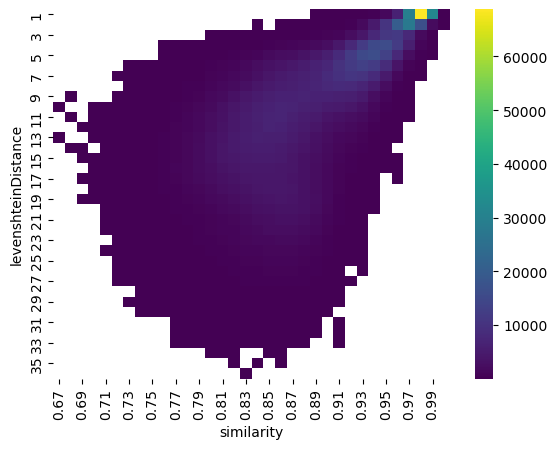

In [12]:
heatmap_data = top_10_df.pivot(index='levenshteinDistance', columns='similarity', values='pairs')
sns.heatmap(heatmap_data, cmap='viridis')

In [14]:
top_10_df[top_10_df['levenshteinDistance']<=2]['similarity'].min()

0.84

# Write results to Neo4j
Also calculate Levenshtein distance while writing. 

In [15]:
start_time = perf_counter()
gds.run_cypher("""
CALL {
    CALL gds.knn.stream("emails", {nodeProperties:"editEmbedding", topk:80, similarityCutoff:0.84})
    YIELD node1, node2, similarity
    WITH gds.util.asNode(node1) AS s, 
    gds.util.asNode(node2) AS t,
    similarity
    WITH s, t, similarity,
    apoc.text.levenshteinDistance(s.address, t.address) AS levenshteinDistance
    WHERE levenshteinDistance <= 2
    MERGE (s)-[r:HAS_SIMILAR_EMBEDDING]->(t)
    ON CREATE SET r.similarity = similarity,
    r.levenshteinDistance = levenshteinDistance
} IN TRANSACTIONS OF 10000 ROWS""")
end_time = perf_counter()
print(end_time - start_time)

270.09353264700076


In [16]:
gds.graph.drop(g_email)

Failed to read from defunct connection ResolvedIPv4Address(('34.28.32.244', 7687)) (ResolvedIPv4Address(('34.28.32.244', 7687)))
Unable to retrieve routing information
Unable to connect to the Neo4j DBMS. Trying again...
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


graphName                                                           emails
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                           141286
relationshipCount                                                        0
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                                0.0
creationTime                           2024-07-17T19:54:35.193112748+00:00
modificationTime                       2024-07-17T19:54:36.432551396+00:00
schema                   {'graphProperties': {}, 'nodes': {'Email': {'e...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Email': {'e...
Name: 0, dtype: object